# PDH generation example

This notebook demonstrates the generation of a Poud Drever Hall error signal using an on-board IQ module.

For pedagogical purposes, the configuration of the IQ module, and the sweep of the piezoelectric actuator using an arbitrary signal generator are performed by-hand, without resorting to the Lockbox module.

In [1]:
# Set environment variable to use a custom configuration file location
import os
os.environ["PYRPL_USER_DIR"] = "../pyrpl_user_dir/"

In [2]:
from pyrpl import Pyrpl
p = Pyrpl("pdh_example")

INFO:pyrpl:All your PyRPL settings will be saved to the config file
    ../pyrpl_user_dir/config\pdh_example.yml
If you would like to restart PyRPL with these settings, type "pyrpl.exe pdh_example" in a windows terminal or 
    from pyrpl import Pyrpl
    p = Pyrpl('pdh_example')
in a python terminal.
INFO:pyrpl.redpitaya:Successfully connected to Redpitaya with hostname 10.214.1.32.


## IQ module configuration (PDH-signal generation)

In [3]:
iq = p.rp.iq0

iq.acbandwidth = 100e3 # high-pass filter the input of the module to remove DC component.
iq.frequency = 5e7 # Modulation frequency up to the Nyquist frequency (67.5 MHz)
iq.bandwidth = [3e6, 3e6] # Use second-order low-pass to filter-out the 2-f component
iq.quadrature_factor = 30 # Make sure that no saturation occurs
iq.phase = 35 # Optmial phase (in degrees) depends on propagation time in the coax
iq.amplitude = 1.0 # amplitude of the modulation (in V)
iq.output_direct = 'out2' # output modulation channel (to the electro-optic modulator)
iq.input = 'in1' # input from the photodiode 

iq0 module should look like the following: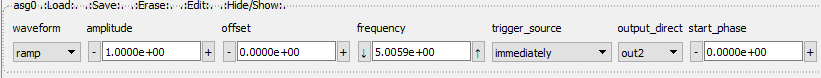

## Arbitrary Signal Generator configuration (piezo sweep)

In [4]:
asg = p.rp.asg0
asg.amplitude = 1 #In V
asg.offset = 0    # In V
asg.frequency = 5 # in Hz
asg.waveform = 'ramp'

asg.trigger_source = "immediately" 
asg.output_direct = "out1"    # To high-voltage amplifier --> To piezo actuator

GUI of the asg module should look like the following:
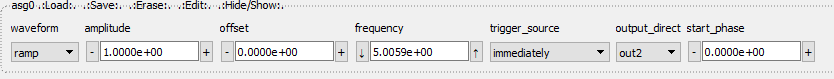

## Scope configuration 1 (trigger on ASG)

In [5]:
scope = p.rp.scope
scope.duration = 0.2 #in s
scope.input1 = 'in1'  # Reflection signal from cavity
scope.input2 = 'iq0' #  PDH error signal
scope.rolling_mode = False # Use actual trigger to synchronize the acquistion

scope.trigger_source = 'asg0'
scope.run_continuous = True    # Acquire data continuously and plot in the scope GUI.
# Let's save the scope state for future use
scope.save_state('autosweep') # state can be loaded with scope.load_state('autosweep')

The error signals should refresh at 5 Hz in the scope GUI: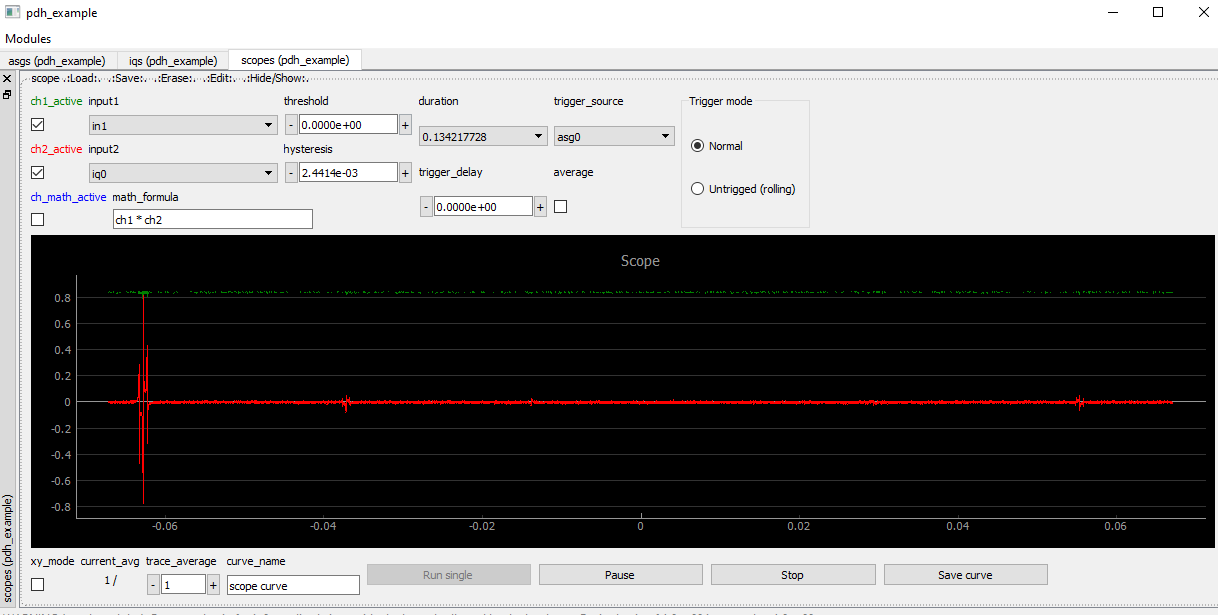

## Scope configuration 2 (trigger on cavity reflection)

In [6]:
scope = p.rp.scope
scope.duration = 0.005 #in s (better resolution of the pic)
scope.input1 = 'in1'  # Reflection signal from cavity
scope.input2 = 'iq0' #  PDH error signal
scope.rolling_mode = False # Use actual trigger to synchronize the acquistion

scope.trigger_source = 'ch1_negative_edge'
scope.threshold = 0.8 # in V
scope.run_continuous = True    # Acquire data continuously and plot in the scope GUI.

# Let's save the scope state for future use
p.rp.scope.save_state('autosweep_zoom')

Error signals in autosweep_zoom state The scope GUI should look like the following (right-click on the load, save, erase items at the top of the panel to manipulate module states graphically): 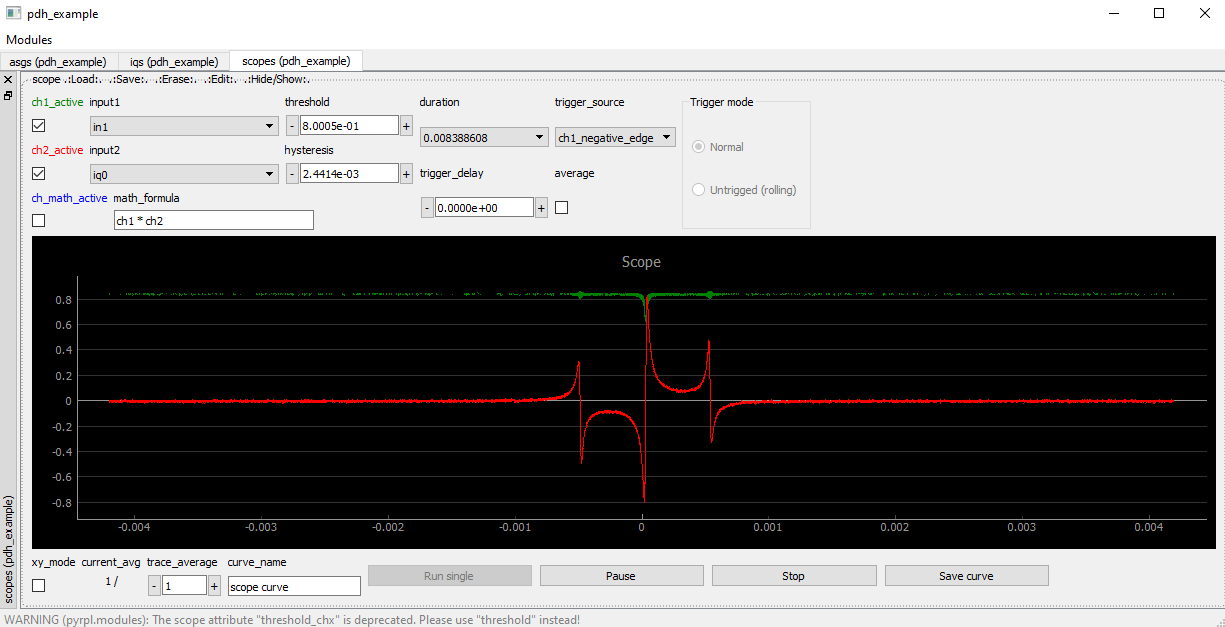

## Find optimal PDH phase 

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np

scope.load_state('autosweep')
scope.duration = 4e-3
TRIGGER_DELAY = 0.6655
scope.trigger_delay = TRIGGER_DELAY

OPTIMAL_ANGLE = 35

angles_iq = np.linspace(-90+OPTIMAL_ANGLE , 90+OPTIMAL_ANGLE, 8)

times = p.rp.scope.times
CH1, CH2 = [], []
for theta in angles_iq:
    iq.phase = theta
    ch1, ch2 = p.rp.scope.single()
    CH1.append(ch1)
    CH2.append(ch2)

In [8]:
import h5py
kwds = dict(times=times, CH1=CH1, CH2=CH2)
with h5py.File("./data/data.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)

## Plot figure

In [2]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
# load data 
kwds = {}
with h5py.File("./data/data.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]

        
CH1_load, CH2_load, times_load = kwds['CH1'], kwds['CH2'], kwds['times']

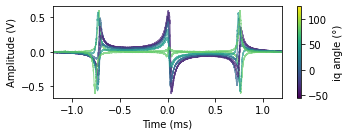

In [13]:
#plot data 
OPTIMAL_ANGLE = 35

angles_iq = np.linspace(-90+OPTIMAL_ANGLE , 90+OPTIMAL_ANGLE, 8)

fig = plt.figure(figsize=(5,2))
TRIGGER_DELAY = 0.66555

for k, vals in enumerate(CH2_load):
    plt.plot((times_load-TRIGGER_DELAY)*1e3, vals, color=plt.cm.viridis(np.abs((angles_iq[k]-OPTIMAL_ANGLE)/120)), 
             linestyle = 'solid', linewidth=1, alpha = 0.7, rasterized=True)
    
ax = plt.gca()
norm = mpl.colors.Normalize(vmin=min(angles_iq), vmax=max(angles_iq))
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis), 
             ax=ax, label=r'iq angle (°)')

plt.xlabel(r'Time (ms)')
plt.xlim( - 0.0012e3, + 0.0012e3)
plt.ylabel(r'Amplitude (V)')
plt.tight_layout()
plt.show()

fig.savefig("./figure_pdh.pdf", dpi=600)